In [ ]:
# Main classes
#!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/keyboard.ndjson" ./raw_data # Karl-Johan
#!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/monkey.ndjson" ./raw_data # Mart
#!gsutil -mq cp "gs://quickdraw_dataset/full/simplified/fish.ndjson" ./raw_data # Tiit

In [1]:
import json
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.display import display
import cv2

import warnings
warnings.filterwarnings('ignore')

In [27]:
def read_sketch_data(file_name:str, max_lines_to_read:int=None, max_nr_elements:int=None, good_only:bool=True)->pd.DataFrame:
  """
  Read from info about one class of sketches data.
  If max_nr_elements==None then all info is read.
  If good_only==False then all sketces info is saved.
  """
  print(f'Reading sketches from {file_name}')
  df = pd.DataFrame(columns= ['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
  nr_elements = 0
  with open(file_name) as f:
    lines = f.readlines()
    print(len(lines))
    for row in lines[30000:]:
      data = json.loads(row)
      df_row = pd.DataFrame.from_dict(data,orient='index').T
      if not df_row['recognized'].iloc[0]:
        continue
      df = df.append([df_row])
      if max_lines_to_read != None:
        nr_elements+=1
        if max_lines_to_read <= nr_elements:
          break
  # get only good pictures
  if good_only:
    df = df[df.recognized == True]

  return df.sample(frac = 1)[:max_nr_elements if max_nr_elements else len(df)]

def read_sketches_data(data_files:list=None, max_lines_to_read:int=None, max_nr_imgs_per_cls:int=None, good_only:bool=True)->pd.DataFrame:
  """"
  Read every desired class info into one dataframe.
  """

  dataframes_dict = dict()
  for class_name in data_files:
    df_sketches = pd.DataFrame(columns= ['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
    df_sketches = df_sketches.append([read_sketch_data(class_name, max_lines_to_read, max_nr_imgs_per_cls,good_only)])
    word = df_sketches.word.iloc[0]
    dataframes_dict[word]=df_sketches
  
  return dataframes_dict

In [28]:
def vector_to_img(vector)->np.array:
  def resize_point(x,y,size_from_original)->tuple:
    return round(x*size_from_original),round(y*size_from_original)

  stroke_locs =  [list(zip(stroke[0],stroke[1]))for stroke in vector]
  image = np.full((100,100),255,dtype=np.uint8)
  for stroke in stroke_locs:
    last_point = resize_point(int(stroke[0][0]),int(stroke[0][1]),0.25)
    for x,y in stroke:
      new_point = resize_point(int(x),int(y),0.25)
      cv2.line(image, last_point, new_point, 0, 2)
      last_point = new_point
  return image

def visualise_sketch(image):
  display(Image.fromarray(image))

def visualise_representative_sketches(dataframes_dict:dict):
  for class_name, df_class in dataframes_dict.items():
    print(class_name)
    visualise_sketch(vector_to_img(df_class[df_class['recognized']==True]['drawing'].iloc[0]))

In [31]:
df_main

,word,countrycode,timestamp,recognized,key_id,drawing,user_valuation
0,fish,SE,2017-03-24 08:13:20.70309 UTC,True,5032798173790208,"[[[193, 107, 54, 21, 0, 15, 73, 122, 162, 170,...",None
0,fish,US,2017-01-23 17:44:45.52386 UTC,True,5524799012995072,"[[[102, 96, 87, 36, 17, 4, 1, 1, 20, 33, 51, 7...",None
0,fish,PH,2017-03-28 06:21:12.52972 UTC,True,5522290026479616,"[[[197, 196, 190, 163, 124, 97, 84, 49, 0, 5, ...",None
0,fish,MX,2017-03-17 18:13:50.71068 UTC,True,5761628052127744,"[[[254, 173, 152, 107, 67, 30, 19, 10, 4, 0, 6...",None
0,fish,TH,2017-03-27 03:43:09.86825 UTC,True,5716373223243776,"[[[75, 84, 105, 150, 179, 209, 234, 245, 254, ...",None


['./raw_data/fish.ndjson']
Reading sketches from ./raw_data/fish.ndjson
134150
Valuate, how recognizable this image is


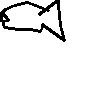

Valuate, how recognizable this image is


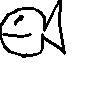

Valuate, how recognizable this image is


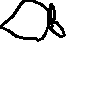

Valuate, how recognizable this image is


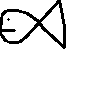

Valuate, how recognizable this image is


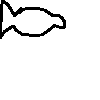

,word,countrycode,timestamp,recognized,key_id,drawing,user_valuation
0,fish,SE,2017-03-24 08:13:20.70309 UTC,True,5032798173790208,"[[[193, 107, 54, 21, 0, 15, 73, 122, 162, 170,...",None
0,fish,US,2017-01-23 17:44:45.52386 UTC,True,5524799012995072,"[[[102, 96, 87, 36, 17, 4, 1, 1, 20, 33, 51, 7...",None
0,fish,PH,2017-03-28 06:21:12.52972 UTC,True,5522290026479616,"[[[197, 196, 190, 163, 124, 97, 84, 49, 0, 5, ...",None
0,fish,MX,2017-03-17 18:13:50.71068 UTC,True,5761628052127744,"[[[254, 173, 152, 107, 67, 30, 19, 10, 4, 0, 6...",None
0,fish,TH,2017-03-27 03:43:09.86825 UTC,True,5716373223243776,"[[[75, 84, 105, 150, 179, 209, 234, 245, 254, ...",None


In [30]:
main_class = 'fish' # 'keyboard' 'monkey'
dir_name = './raw_data'
nr_images_to_value = 10
# import main class
main_data_files = list(filter(lambda x: ('.ndjson' in x) and (main_class in x), os.listdir(dir_name)))
main_data_files = [f'{dir_name}/{file_name}' for file_name in main_data_files]
print(main_data_files)
main_df_raw = read_sketches_data(main_data_files,60000,None,False)[main_class]

bad_examples = main_df_raw[main_df_raw['recognized']==False][:nr_images_to_value//2]
good_examples = main_df_raw[main_df_raw['recognized']==True][:nr_images_to_value//2]

In [43]:
list(df_main.columns).index('user_valuation')

6

Valuate, how recognizable this image is


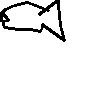

Valuate, how recognizable this image is


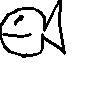

Valuate, how recognizable this image is


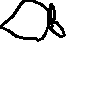

Valuate, how recognizable this image is


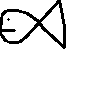

Valuate, how recognizable this image is


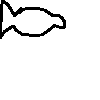

,word,countrycode,timestamp,recognized,key_id,drawing,user_valuation
0,fish,SE,2017-03-24 08:13:20.70309 UTC,True,5032798173790208,"[[[193, 107, 54, 21, 0, 15, 73, 122, 162, 170,...",1
0,fish,US,2017-01-23 17:44:45.52386 UTC,True,5524799012995072,"[[[102, 96, 87, 36, 17, 4, 1, 1, 20, 33, 51, 7...",1
0,fish,PH,2017-03-28 06:21:12.52972 UTC,True,5522290026479616,"[[[197, 196, 190, 163, 124, 97, 84, 49, 0, 5, ...",1
0,fish,MX,2017-03-17 18:13:50.71068 UTC,True,5761628052127744,"[[[254, 173, 152, 107, 67, 30, 19, 10, 4, 0, 6...",1
0,fish,TH,2017-03-27 03:43:09.86825 UTC,True,5716373223243776,"[[[75, 84, 105, 150, 179, 209, 234, 245, 254, ...",1


In [44]:
df_main = pd.concat([bad_examples,good_examples])
df_main['user_valuation'] = 0
use_valuation_idx = list(df_main.columns).index('user_valuation')
for i in range(len(df_main)):
    row = df_main.iloc[i]
    print('Valuate, how recognizable this image is')
    visualise_sketch(vector_to_img(row['drawing']))
    user_valuation = int(input('Value:'))
    df_main.iat[i,use_valuation_idx] = user_valuation

df_main